In [31]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [32]:
# Download model and image
!wget -O dog.jpg https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true
!wget -O tinyyolov2-8.onnx https://github.com/onnx/models/raw/main/validated/vision/object_detection_segmentation/tiny-yolov2/model/tinyyolov2-8.onnx

--2025-07-20 09:27:25--  https://github.com/pjreddie/darknet/blob/master/data/dog.jpg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/refs/heads/master/data/dog.jpg [following]
--2025-07-20 09:27:26--  https://github.com/pjreddie/darknet/raw/refs/heads/master/data/dog.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pjreddie/darknet/refs/heads/master/data/dog.jpg [following]
--2025-07-20 09:27:26--  https://raw.githubusercontent.com/pjreddie/darknet/refs/heads/master/data/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request 

[INFO] Top 6 detections:
  dog: 0.81 (102, 225) → (337, 537)
  car: 0.80 (445, 92) → (694, 182)
  car: 0.73 (449, 75) → (682, 174)
  bicycle: 0.50 (146, 163) → (597, 423)
  dog: 0.39 (147, 230) → (352, 517)


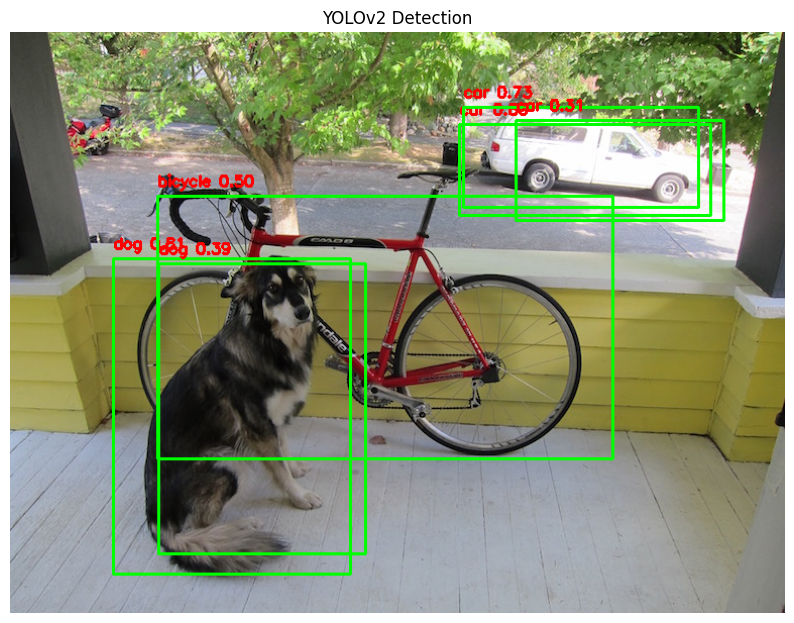

In [ ]:
# VOC labels
labels = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow",
    "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

anchors = [
    (1.08, 1.19), (3.42, 4.41), (6.63, 11.38),
    (9.42, 5.11), (16.62, 10.52)
]

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / e.sum()

# Load image as BGR (YOLOv2 original style), no normalization
img = cv2.imread("dog.jpg")
h_img, w_img, _ = img.shape
resized = cv2.resize(img, (416, 416))
blob = resized.transpose(2, 0, 1)  # HWC to CHW
blob = np.expand_dims(blob, axis=0).astype(np.float32)  # (1, 3, 416, 416)

# Run ONNX
sess = ort.InferenceSession("tinyyolov2-8.onnx")
input_name = sess.get_inputs()[0].name
output = sess.run(None, {input_name: blob})[0]  # (1, 125, 13, 13)
output = output[0]  # remove batch

# Decode
grid_size = 13
num_classes = 20
num_anchors = 5
threshold = 0.3

boxes = []

for y in range(grid_size):
    for x in range(grid_size):
        for a in range(num_anchors):
            offset = a * (num_classes + 5)
            cell = output[offset:offset + 25, y, x]

            tx, ty, tw, th, tc = cell[:5]
            confidence = sigmoid(tc)
            if confidence < 0.05:
                continue

            class_scores = softmax(cell[5:])
            class_id = np.argmax(class_scores)
            score = confidence * class_scores[class_id]
            if score < threshold:
                continue

            # YOLO decode
            cx = (sigmoid(tx) + x) / grid_size
            cy = (sigmoid(ty) + y) / grid_size
            w = np.exp(tw) * anchors[a][0] / grid_size
            h = np.exp(th) * anchors[a][1] / grid_size

            x_min = int((cx - w / 2) * w_img)
            y_min = int((cy - h / 2) * h_img)
            x_max = int((cx + w / 2) * w_img)
            y_max = int((cy + h / 2) * h_img)

            boxes.append((x_min, y_min, x_max, y_max, score, labels[class_id]))

# Debug: print top 5 detections
boxes = sorted(boxes, key=lambda b: b[4], reverse=True)
print(f"[INFO] Top {len(boxes)} detections:")
for box in boxes[:5]:
    print(f"  {box[5]}: {box[4]:.2f} ({box[0]}, {box[1]}) → ({box[2]}, {box[3]})")

# Draw
for x1, y1, x2, y2, score, label in boxes:
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, f"{label} {score:.2f}", (x1, max(y1 - 10, 0)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

# Show
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("YOLOv2 Detection")
plt.show()